In [53]:
from pathlib import Path

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import sklearn
import seaborn as sns

In [54]:
data = pd.read_parquet(Path("data") / "train.parquet")
data.head()

data_test = pd.read_parquet(Path("data") / "final_test.parquet")
data.head()

,counter_id,counter_name,site_id,site_name,bike_count,date,counter_installation_date,coordinates,counter_technical_id,latitude,longitude,log_bike_count
48321,100007049-102007049,28 boulevard Diderot E-O,100007049,28 boulevard Diderot,0.0,2020-09-01 02:00:00,2013-01-18,"48.846028,2.375429",Y2H15027244,48.846028,2.375429,0.000000
48324,100007049-102007049,28 boulevard Diderot E-O,100007049,28 boulevard Diderot,1.0,2020-09-01 03:00:00,2013-01-18,"48.846028,2.375429",Y2H15027244,48.846028,2.375429,0.693147
48327,100007049-102007049,28 boulevard Diderot E-O,100007049,28 boulevard Diderot,0.0,2020-09-01 04:00:00,2013-01-18,"48.846028,2.375429",Y2H15027244,48.846028,2.375429,0.000000
48330,100007049-102007049,28 boulevard Diderot E-O,100007049,28 boulevard Diderot,4.0,2020-09-01 15:00:00,2013-01-18,"48.846028,2.375429",Y2H15027244,48.846028,2.375429,1.609438
48333,100007049-102007049,28 boulevard Diderot E-O,100007049,28 boulevard Diderot,9.0,2020-09-01 18:00:00,2013-01-18,"48.846028,2.375429",Y2H15027244,48.846028,2.375429,2.302585


In [55]:
data_daily = (
    data
    .groupby(pd.Grouper(freq="1D", key="date"))
    ["log_bike_count"]
    .sum()
    .to_frame()
    .reset_index()
)

# Add a Covid 19 Lockdown Variable

### Solution 1 - Add Column of 1 when in Lockdown

In [66]:
expanded_data = data

date_ranges = [
    ("2020-10-30", "2020-12-15"),
    ("2021-03-20", "2021-05-19"),
]

expanded_data["Covid-19"] = 0 
for start, end in date_ranges:
    expanded_data["Covid-19"] |= expanded_data["date"].between(start, end).astype(int)

expanded_data.head()


,counter_id,counter_name,site_id,site_name,bike_count,date,counter_installation_date,coordinates,counter_technical_id,latitude,longitude,log_bike_count,Covid-19
48321,100007049-102007049,28 boulevard Diderot E-O,100007049,28 boulevard Diderot,0.0,2020-09-01 02:00:00,2013-01-18,"48.846028,2.375429",Y2H15027244,48.846028,2.375429,0.000000,0
48324,100007049-102007049,28 boulevard Diderot E-O,100007049,28 boulevard Diderot,1.0,2020-09-01 03:00:00,2013-01-18,"48.846028,2.375429",Y2H15027244,48.846028,2.375429,0.693147,0
48327,100007049-102007049,28 boulevard Diderot E-O,100007049,28 boulevard Diderot,0.0,2020-09-01 04:00:00,2013-01-18,"48.846028,2.375429",Y2H15027244,48.846028,2.375429,0.000000,0
48330,100007049-102007049,28 boulevard Diderot E-O,100007049,28 boulevard Diderot,4.0,2020-09-01 15:00:00,2013-01-18,"48.846028,2.375429",Y2H15027244,48.846028,2.375429,1.609438,0
48333,100007049-102007049,28 boulevard Diderot E-O,100007049,28 boulevard Diderot,9.0,2020-09-01 18:00:00,2013-01-18,"48.846028,2.375429",Y2H15027244,48.846028,2.375429,2.302585,0


No all hours have bike count.

In [57]:
expanded_data_daily = (
    expanded_data
    .groupby(pd.Grouper(freq="1D", key="date"))
    ["log_bike_count"]
    .sum()
    .to_frame()
    .reset_index()
)

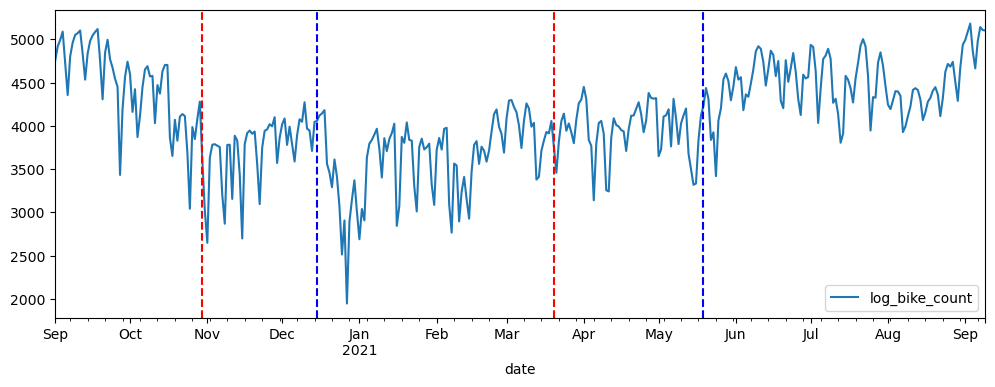

In [58]:
fig, ax = plt.subplots(figsize=(12, 4))
expanded_data_daily.plot(x="date", y="log_bike_count", ax=ax)

vertical_lines = [("2020-10-30", "2020-12-15"), ("2021-03-20", "2021-05-19")]
for start_date, end_date in vertical_lines:
    # Add lines at start and end of the ranges
    ax.axvline(pd.to_datetime(start_date), color='red', linestyle='--', label=start_date)
    ax.axvline(pd.to_datetime(end_date), color='blue', linestyle='--', label=end_date)


Conclusion: Doesn't seem to be that significant, a little random, maybe put 1 in the whole period though it's arbitrary.

### Solution 2 - Add a Restrictions Index

In [59]:
covid_19_index = pd.read_csv(Path("data") / "Covid_19_Index.csv")
covid_19_index["date"] = pd.to_datetime(covid_19_index["Date"], format='%Y%m%d')
covid_19_index = (
    covid_19_index
    .query("CountryName == 'France'")
    .query(f"date >= '{min}' and date <= '{max}'")
)
covid_19_index.head()

/var/folders/b3/l_t9dzy13rz2smp7vyx9352h0000gn/T/ipykernel_31860/3197237612.py:1: DtypeWarning: Columns (2,3,44,45) have mixed types. Specify dtype option on import or set low_memory=False.
  covid_19_index = pd.read_csv(Path("data") / "Covid_19_Index.csv")


,CountryName,CountryCode,RegionName,RegionCode,Jurisdiction,Date,C1M_combined_numeric,C1M_combined,C2M_combined_numeric,C2M_combined,...,V4..summary.,ConfirmedCases,ConfirmedDeaths,MajorityVaccinated,PopulationVaccinated,StringencyIndex_Average,GovernmentResponseIndex_Average,ContainmentHealthIndex_Average,EconomicSupportIndex,date
151129,France,FRA,NaN,NaN,NAT_TOTAL,20200901,1.0,1G,1.5,2T,...,NaN,309247.0,30525.0,NV,0.0,46.76,54.69,51.79,75.0,2020-09-01
151130,France,FRA,NaN,NaN,NAT_TOTAL,20200902,1.0,1G,1.5,2T,...,NaN,316047.0,30547.0,NV,0.0,46.76,54.69,51.79,75.0,2020-09-02
151131,France,FRA,NaN,NaN,NAT_TOTAL,20200903,1.5,2T,1.5,2T,...,NaN,322935.0,30564.0,NV,0.0,48.61,55.73,52.98,75.0,2020-09-03
151132,France,FRA,NaN,NaN,NAT_TOTAL,20200904,1.5,2T,1.5,2T,...,NaN,331578.0,30542.0,NV,0.0,48.61,55.73,52.98,75.0,2020-09-04
151133,France,FRA,NaN,NaN,NAT_TOTAL,20200905,1.5,2T,1.5,2T,...,NaN,340013.0,30553.0,NV,0.0,48.61,55.73,52.98,75.0,2020-09-05


There are two indeces that make sense to consider: StringencyIndex_Average and ContainmentHealthIndex_Average. They don't differ much, but use different critea. 
- https://github.com/OxCGRT/covid-policy-dataset/blob/main/documentation_and_codebook.md#calculation-of-policy-indices (see calculation of indices)
- https://github.com/OxCGRT/covid-policy-dataset/blob/main/documentation_and_codebook.md (overview of variables)
- https://github.com/OxCGRT/covid-policy-dataset?tab=readme-ov-file (main page)

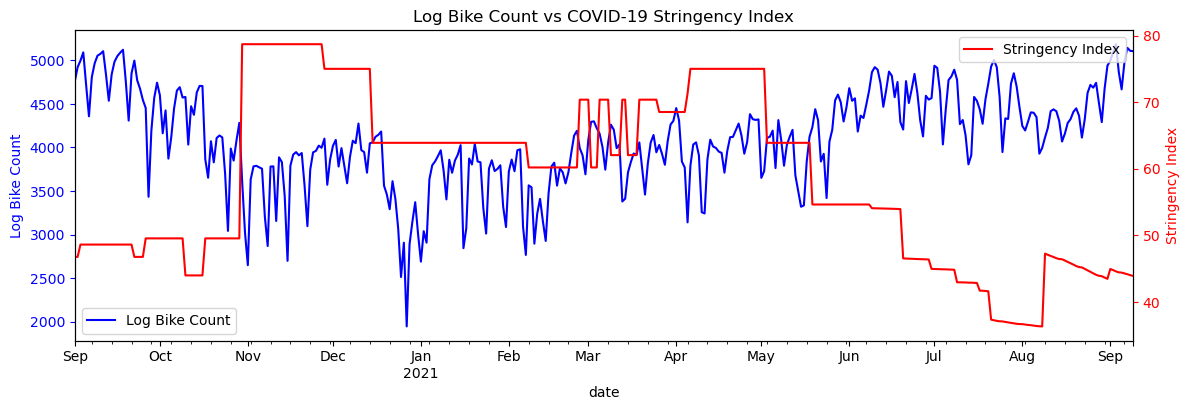

In [61]:
# Create the figure and axis
fig, ax1 = plt.subplots(figsize=(12, 4))

# Plot the first dataset
data_daily.plot(x="date", y="log_bike_count", ax=ax1, label="Log Bike Count", color='blue')
ax1.set_ylabel("Log Bike Count", color="blue")
ax1.tick_params(axis='y', colors="blue")

# Create a second y-axis
ax2 = ax1.twinx()

# Plot the second dataset
covid_19_index.plot(x="date", y="StringencyIndex_Average", ax=ax2, label="Stringency Index", color='red')
ax2.set_ylabel("Stringency Index", color="red")
ax2.tick_params(axis='y', colors="red")

# Adjust and show
fig.tight_layout()
plt.title("Log Bike Count vs COVID-19 Stringency Index")
plt.show()

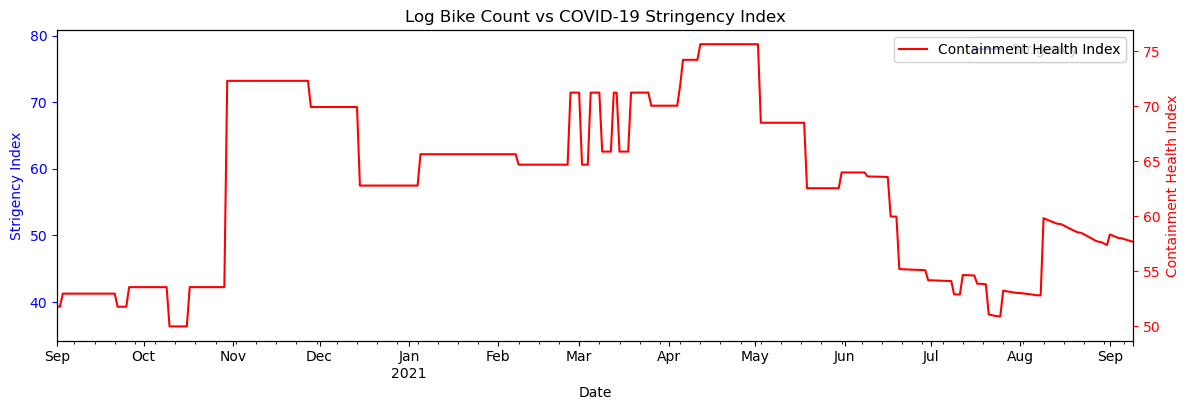

In [62]:
# Create the figure and axis
fig, ax1 = plt.subplots(figsize=(12, 4))

# Plot the first dataset
covid_19_index.plot(x="Date", y="StringencyIndex_Average", ax=ax1, label="Strigency Index", color='blue')
ax1.set_ylabel("Strigency Index", color="blue")
ax1.tick_params(axis='y', colors="blue")

# Create a second y-axis
ax2 = ax1.twinx()

# Plot the second dataset
covid_19_index.plot(x="date", y="ContainmentHealthIndex_Average", ax=ax2, label="Containment Health Index", color='red')
ax2.set_ylabel("Containment Health Index", color="red")
ax2.tick_params(axis='y', colors="red")

# Adjust and show
fig.tight_layout()
plt.title("Log Bike Count vs COVID-19 Stringency Index")
plt.show()

Both are very similar. See the one that is the best.

### Solution 3 - Add rate of incidence or R coefficient

In [63]:
covid_19 = pd.read_csv(Path("data") / "Covid_19.csv")
covid_19["date"] = pd.to_datetime(covid_19["date"])
covid_19 = (
    covid_19
    .query("dep == 75 and date > '2020-09-01' and date < '2021-10-01'")
    .dropna(subset=['R'])
)
covid_19.head()

/var/folders/b3/l_t9dzy13rz2smp7vyx9352h0000gn/T/ipykernel_31860/2783328848.py:1: DtypeWarning: Columns (0) have mixed types. Specify dtype option on import or set low_memory=False.
  covid_19 = pd.read_csv(Path("data") / "Covid_19.csv")


,dep,date,reg,lib_dep,lib_reg,tx_pos,tx_incid,TO,R,hosp,...,dchosp,reg_rea,incid_hosp,incid_rea,incid_rad,incid_dchosp,reg_incid_rea,pos,pos_7j,cv_dose1
90171,75,2020-09-05,11,Paris,Île-de-France,6.32,181.45,0.156931,1.00,295,...,1814,180,9.0,2.0,5.0,0.0,6.0,324.0,3898.0,NaN
90174,75,2020-09-08,11,Paris,Île-de-France,6.39,186.89,0.173496,0.94,318,...,1820,199,16.0,5.0,19.0,3.0,17.0,786.0,4015.0,NaN
90178,75,2020-09-12,11,Paris,Île-de-France,7.00,208.12,0.184830,0.93,333,...,1825,212,15.0,4.0,16.0,1.0,19.0,270.0,4471.0,NaN
90181,75,2020-09-15,11,Paris,Île-de-France,7.65,225.16,0.214473,0.92,371,...,1828,246,57.0,12.0,28.0,3.0,34.0,936.0,4837.0,NaN
90185,75,2020-09-19,11,Paris,Île-de-France,8.54,254.58,0.213601,1.01,325,...,1840,245,42.0,9.0,57.0,5.0,18.0,487.0,5469.0,NaN


Data Description - https://www.data.gouv.fr/fr/datasets/60190d00a7273a8100dd4d38/

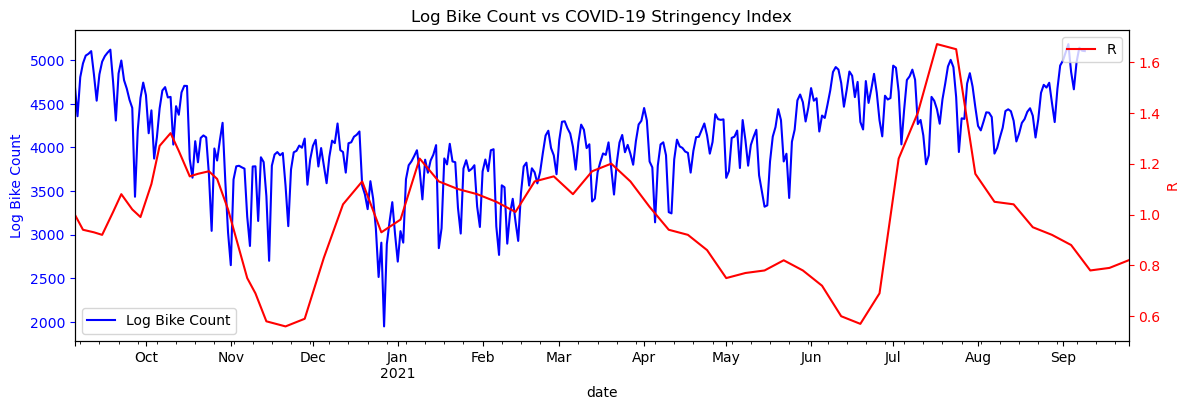

In [64]:
# Create the figure and axis
fig, ax1 = plt.subplots(figsize=(12, 4))

# Plot the first dataset
data_daily.plot(x="date", y="log_bike_count", ax=ax1, label="Log Bike Count", color='blue')
ax1.set_ylabel("Log Bike Count", color="blue")
ax1.tick_params(axis='y', colors="blue")

# Create a second y-axis
ax2 = ax1.twinx()

# Plot the second datase
covid_19.plot(x="date", y="R", color="red", ax=ax2)
ax2.set_ylabel("R", color="red")
ax2.tick_params(axis='y', colors="red")

# Adjust and show
fig.tight_layout()
plt.title("Log Bike Count vs COVID-19 Stringency Index")
plt.show()

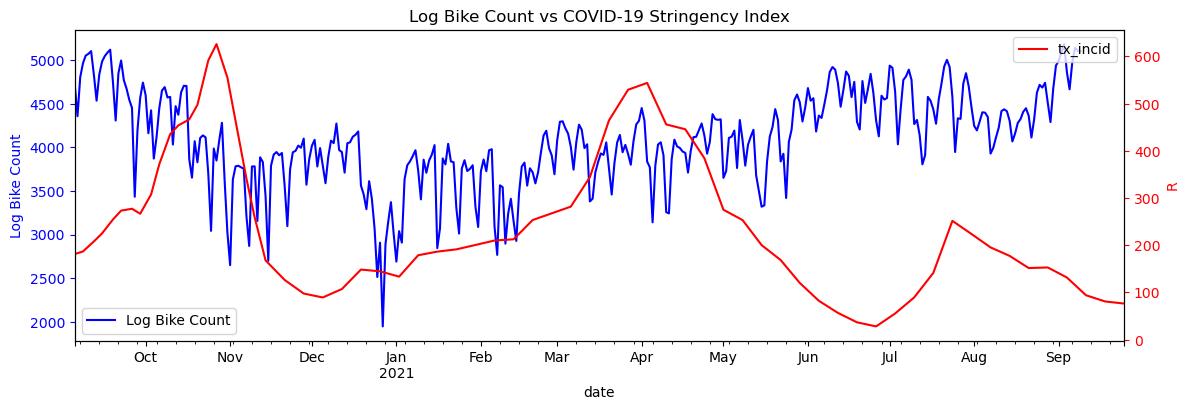

In [65]:
# Create the figure and axis
fig, ax1 = plt.subplots(figsize=(12, 4))

# Plot the first dataset
data_daily.plot(x="date", y="log_bike_count", ax=ax1, label="Log Bike Count", color='blue')
ax1.set_ylabel("Log Bike Count", color="blue")
ax1.tick_params(axis='y', colors="blue")

# Create a second y-axis
ax2 = ax1.twinx()

# Plot the second datase
covid_19.plot(x="date", y="tx_incid", color="red", ax=ax2)
ax2.set_ylabel("R", color="red")
ax2.tick_params(axis='y', colors="red")

# Adjust and show
fig.tight_layout()
plt.title("Log Bike Count vs COVID-19 Stringency Index")
plt.show()

They don't seem like good proxis for the effects of covid-19.